In [51]:
import os
import yaml
from glob import glob
from tqdm import tqdm
from pprint import pprint
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
from astropy.visualization import make_lupton_rgb

from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure
from mejiro.instruments.hst import HST
from mejiro.instruments.roman import Roman
from mejiro.instruments.lsst import LSST
from mejiro.instruments.hwo import HWO
from mejiro.utils import util

# read configuration file
with open('/grad/bwedig/mejiro/mejiro/data/mejiro_config/hwo.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.SafeLoader)

In [52]:
if config['dev']:
    config['pipeline_label'] += '_dev'

In [53]:
lens_dir = os.path.join(config['data_dir'], config['pipeline_label'], '02')
lenses = util.unpickle_all(lens_dir)
print(f'Found {len(lenses)} strong lens(es) in {lens_dir}')

name_snr_pairs = util.unpickle('/data/bwedig/mejiro/hwo/snr/name_snr_pairs.pkl')
snr_dict = dict(name_snr_pairs)

# Sort lenses by SNR, matching on exposure.synthetic_image.strong_lens.name
sorted_lenses = sorted(
    lenses,
    key=lambda lens: snr_dict.get(lens.name, -np.inf),
    reverse=True
)

Found 370 strong lens(es) in /data/bwedig/mejiro/hwo_dev/02


In [54]:
print(snr_dict)

{'hwo_00000105': 1135.225656242168, 'hwo_00000200': 870.5439535068108, 'hwo_00000220': 286.12114470891385, 'hwo_00000005': 247.9612428819445, 'hwo_00000244': 201.30116875343424, 'hwo_00000170': 297.61719484481404, 'hwo_00000293': 246.63311090923725, 'hwo_00000382': 287.19158555089837, 'hwo_00000231': 491.247509693775, 'hwo_00000239': 367.5275037773806, 'hwo_00000370': 321.0429995008411, 'hwo_00000632': 471.6016978064157, 'hwo_00000565': 384.8074538308667, 'hwo_00001385': 296.83801372923153, 'hwo_00000025': 651.8161297606053, 'hwo_00001363': 293.1913366155187, 'hwo_00001440': 260.302107547937, 'hwo_00001296': 700.6981255702597, 'hwo_00001444': 262.92721140034524, 'hwo_00000408': 788.5467727229412, 'hwo_00001549': 498.02411418365324, 'hwo_00000536': 357.3275442656887, 'hwo_00000882': 316.7991863387021, 'hwo_00001535': 597.2318388920496, 'hwo_00000655': 383.8422224947091, 'hwo_00001557': 570.7741781075255, 'hwo_00001509': 1212.65734306466, 'hwo_00000515': 423.83153512713017, 'hwo_00000306

In [55]:
sample = lenses[57]
# pprint(sample.physical_params['magnitudes'])

In [56]:
# sample.physical_params['magnitudes']['source']['J'] -= 1.5
# sample.physical_params['magnitudes']['source']['F814W'] -= 1.5
# sample.physical_params['magnitudes']['source']['i'] -= 1.5

fov_arcsec = 3

In [57]:
hwo = HWO()
lsst = LSST()
hst = HST()

hwo_psf_kwargs = hwo.get_psf_kwargs(band='I')
pprint(hwo_psf_kwargs)

hst_psf_kwargs = hst.get_psf_kwargs(band='F814W')
pprint(hst_psf_kwargs)

{'fwhm': 0.02508122748185179, 'psf_type': 'GAUSSIAN'}
{'fwhm': 0.074, 'psf_type': 'GAUSSIAN'}


Scene size: 3.0080284244368225 arcsec, 525 pixels at pixel scale 0.005729577951308233 arcsec/pix
Synthetic image calculation time: 5.814 s


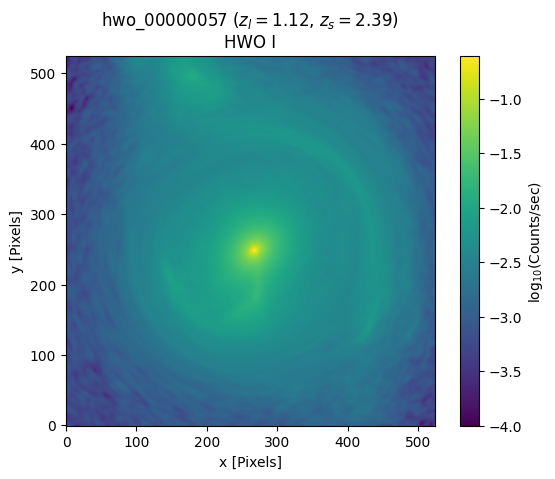

In [58]:
synthetic_image_hwo = SyntheticImage(strong_lens=deepcopy(sample),
                                     instrument=hwo,
                                     band='I',
                                     fov_arcsec=fov_arcsec,
                                     kwargs_psf=hwo_psf_kwargs,
                                     verbose=True)
synthetic_image_hwo.plot()

Scene size: 3.12 arcsec, 39 pixels at pixel scale 0.08 arcsec/pix
Synthetic image calculation time: 0.059 s


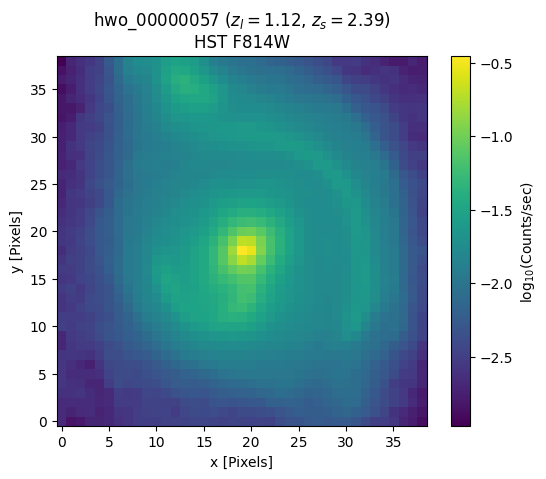

In [59]:
synthetic_image_hst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=hst,
                                 band='F814W',
                                 fov_arcsec=fov_arcsec,
                                 kwargs_psf=hst_psf_kwargs,
                                 verbose=True)
synthetic_image_hst.plot()

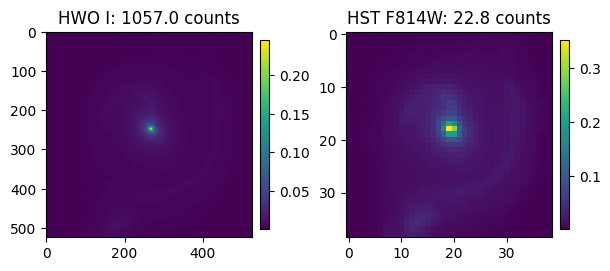

In [60]:
_, ax = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)

im0 = ax[0].imshow(synthetic_image_hwo.image)
ax[0].set_title(f'HWO I: {np.sum(synthetic_image_hwo.image):.1f} counts')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(synthetic_image_hst.image)
ax[1].set_title(f'HST F814W: {np.sum(synthetic_image_hst.image):.1f} counts')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

plt.show()

Scene size: 3.0 arcsec, 15 pixels at pixel scale 0.2 arcsec/pix
Synthetic image calculation time: 0.009 s


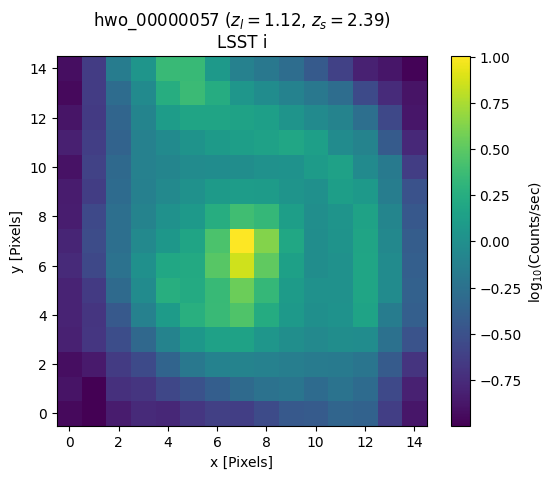

In [61]:
synthetic_image_lsst = SyntheticImage(strong_lens=deepcopy(sample),
                                 instrument=lsst,
                                 band='i',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
synthetic_image_lsst.plot()

Exposure calculation time with galsim engine: 0.058 s


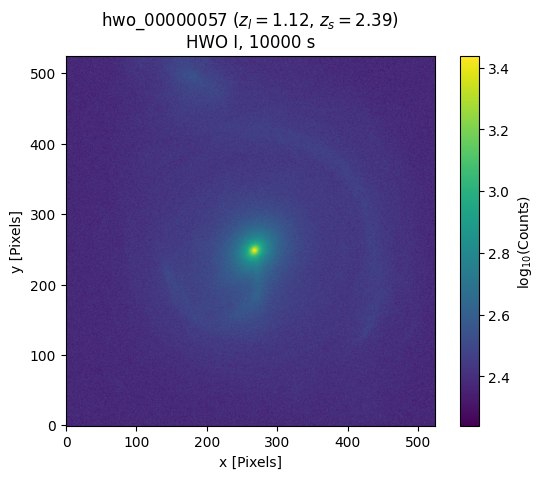

In [62]:
exposure_hwo = Exposure(synthetic_image=synthetic_image_hwo,
                        exposure_time=10000,
                        verbose=True)
exposure_hwo.plot()

Exposure calculation time with galsim engine: 0.03 s


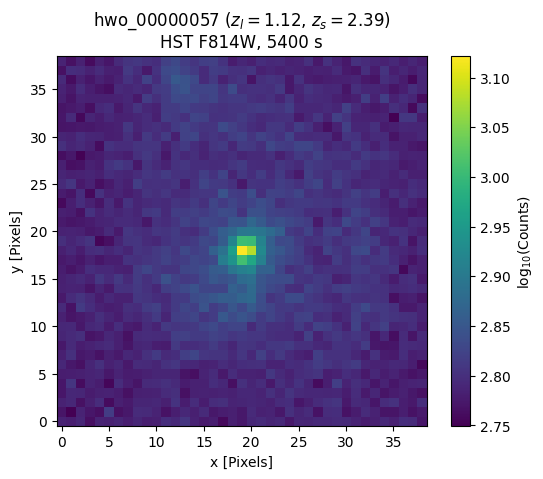

In [63]:
exposure_hst = Exposure(synthetic_image=synthetic_image_hst,
                    exposure_time=5400,
                    engine='galsim',
                    verbose=True)
exposure_hst.plot()

Exposure calculation time with lenstronomy engine: 0.008 s


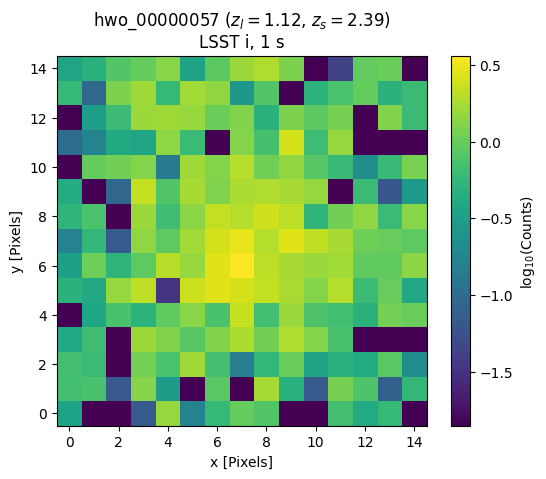

In [64]:
exposure_lsst = Exposure(synthetic_image=synthetic_image_lsst,
                    exposure_time=1,
                    engine='lenstronomy',
                    engine_params={'obs_config_kwargs': {
                    'band': 'i', 
                    'psf_type': 'GAUSSIAN', 
                    'coadd_years': 10
                }},
                    verbose=True)
exposure_lsst.plot()

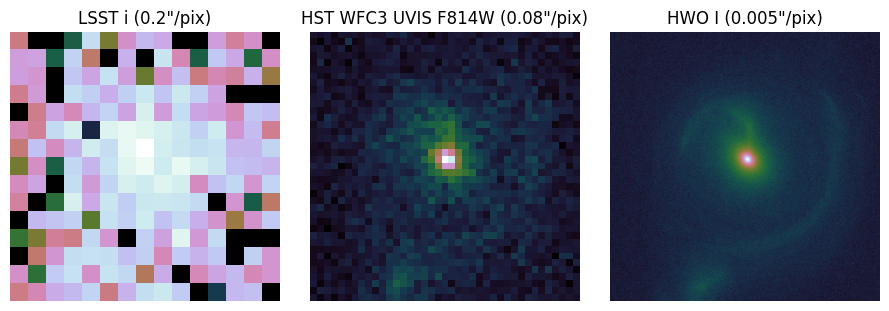

In [65]:
f, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)
ax[0].imshow(np.log10(exposure_lsst.exposure),cmap='cubehelix')
ax[0].set_title('LSST i (0.2"/pix)')
ax[1].imshow(np.log10(exposure_hst.exposure),cmap='cubehelix')
ax[1].set_title('HST WFC3 UVIS F814W (0.08"/pix)')
ax[2].imshow(np.log10(exposure_hwo.exposure),cmap='cubehelix')
ax[2].set_title('HWO I (0.005"/pix)')
for a in ax.flatten():
    a.axis('off')
plt.savefig('/grad/bwedig/mejiro/projects/hwo/figures/compare_instruments.png', dpi=600)
plt.show()

Scene size: 3.0080284244368225 arcsec, 525 pixels at pixel scale 0.005729577951308233 arcsec/pix
Synthetic image calculation time: 429.174 s


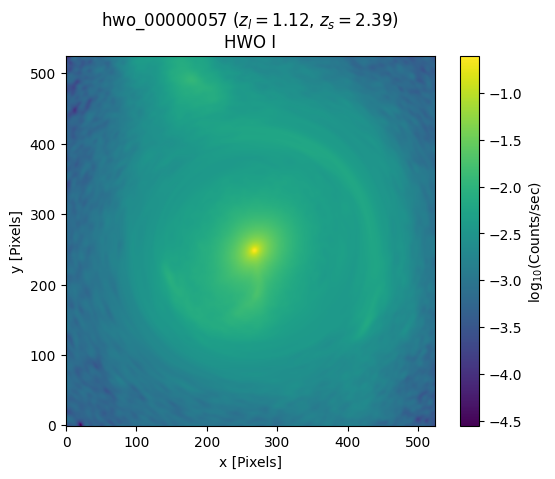

Scene size: 3.12 arcsec, 39 pixels at pixel scale 0.08 arcsec/pix
Synthetic image calculation time: 6.482 s


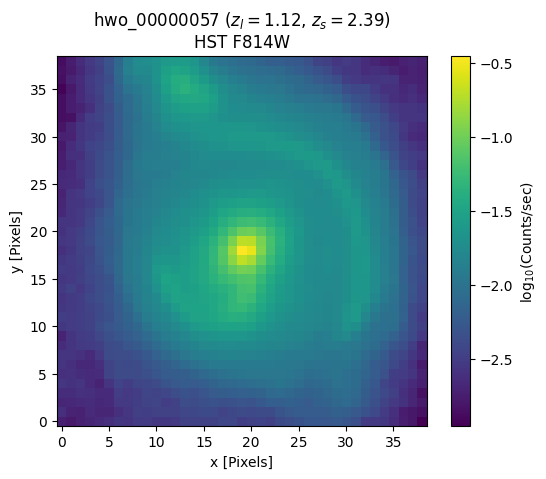

Scene size: 3.0 arcsec, 15 pixels at pixel scale 0.2 arcsec/pix
Synthetic image calculation time: 5.505 s


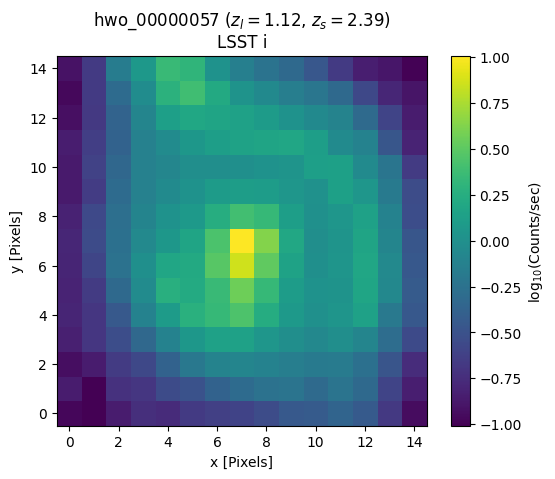

In [66]:
with_substructure = deepcopy(sample)
with_substructure.quick_add()

synthetic_image_hwo_with = SyntheticImage(strong_lens=with_substructure,
                                     instrument=hwo,
                                     band='I',
                                     fov_arcsec=fov_arcsec,
                                     kwargs_psf=hwo_psf_kwargs,
                                     verbose=True)
synthetic_image_hwo_with.plot()

synthetic_image_hst_with = SyntheticImage(strong_lens=with_substructure,
                                 instrument=hst,
                                 band='F814W',
                                 fov_arcsec=fov_arcsec,
                                 kwargs_psf=hst_psf_kwargs,
                                 verbose=True)
synthetic_image_hst_with.plot()

synthetic_image_lsst_with = SyntheticImage(strong_lens=with_substructure,
                                 instrument=lsst,
                                 band='i',
                                 fov_arcsec=fov_arcsec,
                                 verbose=True)
synthetic_image_lsst_with.plot()

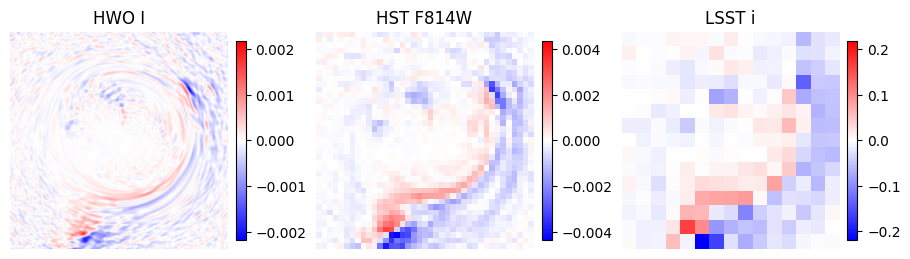

In [67]:
from matplotlib.colors import CenteredNorm

_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im0 = ax[0].imshow(synthetic_image_hwo_with.image - synthetic_image_hwo.image, norm=CenteredNorm(), cmap='bwr')
ax[0].set_title('HWO I')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(synthetic_image_hst_with.image - synthetic_image_hst.image, norm=CenteredNorm(), cmap='bwr')
ax[1].set_title('HST F814W')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(synthetic_image_lsst_with.image - synthetic_image_lsst.image, norm=CenteredNorm(), cmap='bwr')
ax[2].set_title('LSST i')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax.flatten():
    a.axis('off')

plt.show()

Exposure calculation time with galsim engine: 0.06 s
Exposure calculation time with galsim engine: 0.019 s


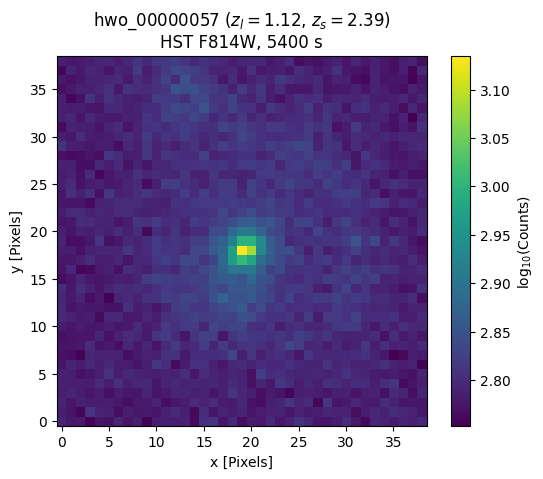

Exposure calculation time with lenstronomy engine: 5.575 s


In [75]:
exposure_hwo_with = Exposure(synthetic_image=synthetic_image_hwo_with,
                        exposure_time=10000,
                        verbose=True)
# exposure_hwo_with.plot()

exposure_hst_with = Exposure(synthetic_image=synthetic_image_hst_with,
                    exposure_time=5400,
                    engine='galsim',
                    verbose=True)
exposure_hst_with.plot()

exposure_lsst_with = Exposure(synthetic_image=synthetic_image_lsst_with,
                    exposure_time=1,
                    engine='lenstronomy',
                    engine_params={'obs_config_kwargs': {
                    'band': 'i', 
                    'psf_type': 'GAUSSIAN', 
                    'coadd_years': 10
                }},
                    verbose=True)
# exposure_lsst_with.plot()

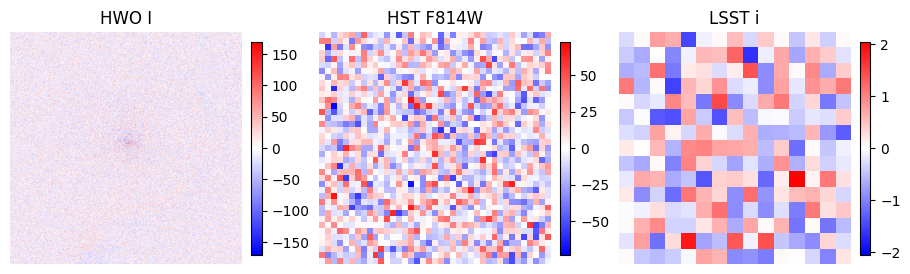

In [69]:
_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im0 = ax[0].imshow(exposure_hwo_with.exposure - exposure_hwo.exposure, norm=CenteredNorm(), cmap='bwr')
ax[0].set_title('HWO I')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(exposure_hst_with.exposure - exposure_hst.exposure, norm=CenteredNorm(), cmap='bwr')
ax[1].set_title('HST F814W')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(exposure_lsst_with.exposure - exposure_lsst.exposure, norm=CenteredNorm(), cmap='bwr')
ax[2].set_title('LSST i')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax.flatten():
    a.axis('off')

plt.show()

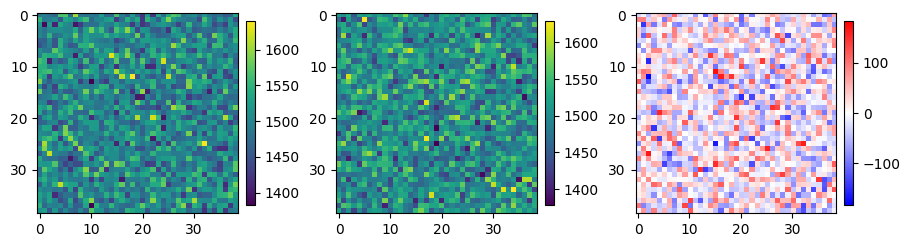

In [70]:
_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im0 = ax[0].imshow(exposure_hst_with.noise)
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(exposure_hst.noise)
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(exposure_hst_with.noise - exposure_hst.noise, norm=CenteredNorm(), cmap='bwr')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()

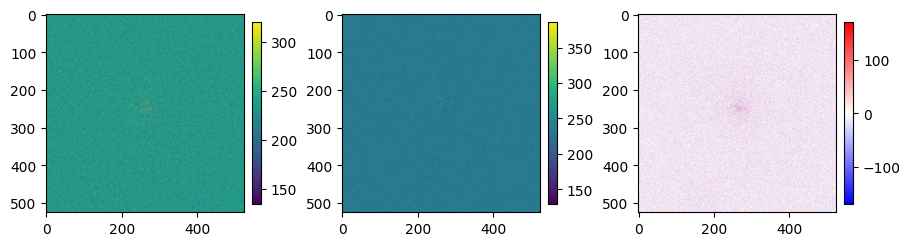

In [71]:
_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

im0 = ax[0].imshow(exposure_hwo_with.noise)
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(exposure_hwo.noise)
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(exposure_hwo_with.noise - exposure_hwo.noise, norm=CenteredNorm(), cmap='bwr')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

plt.show()

HWO pixel scale: 0.005729577951308233 arcsec / pix arcsec/pix
Radius: 34.91 pixels, mask shape: (525, 525)


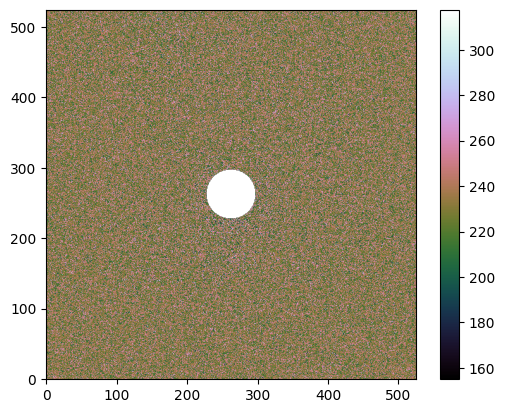

In [72]:
hwo_pixel_scale = hwo.get_pixel_scale('I')
print(f'HWO pixel scale: {hwo_pixel_scale} arcsec/pix')

# radius in arcseconds and convert to pixels using the HWO pixel scale (arcsec/pix)
radius_arcsec = 0.2
pix_radius = radius_arcsec / hwo_pixel_scale.value

# build circular mask centered on the central pixel
ny, nx = exposure_hwo_with.noise.shape
cy, cx = ny // 2, nx // 2
y, x = np.indices((ny, nx))
mask = ((x - cx) ** 2 + (y - cy) ** 2) <= (pix_radius ** 2)

print(f'Radius: {pix_radius:.2f} pixels, mask shape: {mask.shape}')

# invert mask so center is masked (set center to NaN)
masked = np.where(mask, np.nan, exposure_hwo_with.noise)
im = plt.imshow(masked, cmap='cubehelix', origin='lower')
plt.colorbar()
plt.show()

In [73]:
def mask_central_circle(image, radius_arcsec, pixel_scale, center=None, fill_value=np.nan):
    pix_radius = radius_arcsec / pixel_scale.value

    ny, nx = image.shape
    if center is None:
        cy, cx = ny // 2, nx // 2
    else:
        cy, cx = center

    y, x = np.indices((ny, nx))
    mask = ((x - cx) ** 2 + (y - cy) ** 2) <= (pix_radius ** 2)

    return np.where(mask, fill_value, image)

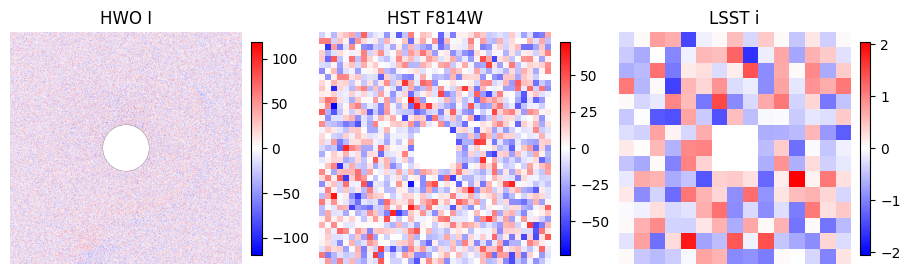

In [74]:
_, ax = plt.subplots(1, 3, figsize=(9, 3), constrained_layout=True)

radius_arcsec = 0.3

hwo_pixel_scale = hwo.get_pixel_scale('I')
hst_pixel_scale = hst.get_pixel_scale('F814W')
lsst_pixel_scale = lsst.get_pixel_scale('i')

im0 = ax[0].imshow(mask_central_circle(exposure_hwo_with.exposure - exposure_hwo.exposure, radius_arcsec, hwo_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[0].set_title('HWO I')
plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

im1 = ax[1].imshow(mask_central_circle(exposure_hst_with.exposure - exposure_hst.exposure, radius_arcsec, hst_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[1].set_title('HST F814W')
plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

im2 = ax[2].imshow(mask_central_circle(exposure_lsst_with.exposure - exposure_lsst.exposure, radius_arcsec, lsst_pixel_scale), norm=CenteredNorm(), cmap='bwr')
ax[2].set_title('LSST i')
plt.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)

for a in ax.flatten():
    a.axis('off')

plt.show()